## second level analysis

In [1]:
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
%matplotlib inline
import matplotlib.pyplot as plt

201007-10:18:54,358 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### check 1st level contrasts

In [2]:
from glob import glob
spmT_images = glob('/output/first_level/1stLevel/sub-06/con*')
spmT_images

['/output/first_level/1stLevel/sub-06/con_0001.nii',
 '/output/first_level/1stLevel/sub-06/con_0004.nii',
 '/output/first_level/1stLevel/sub-06/con_0002.nii',
 '/output/first_level/1stLevel/sub-06/con_0003.nii',
 '/output/first_level/1stLevel/sub-06/con_0005.nii']

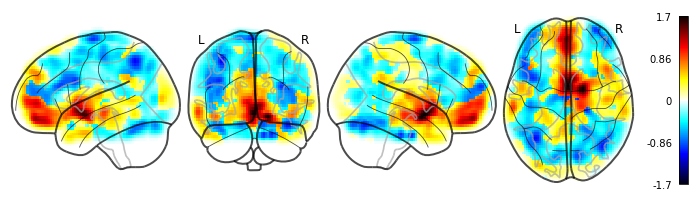

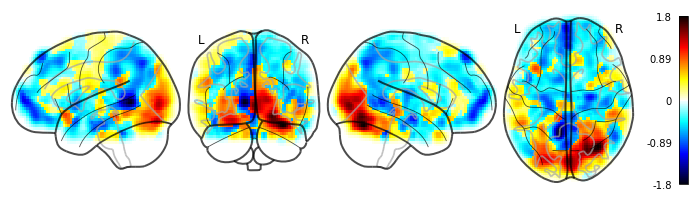

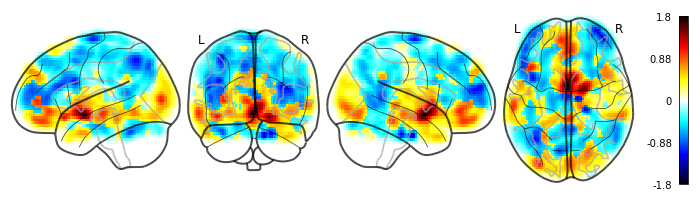

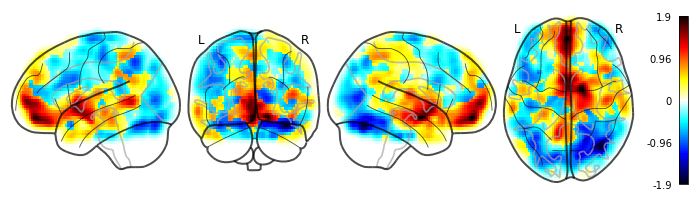

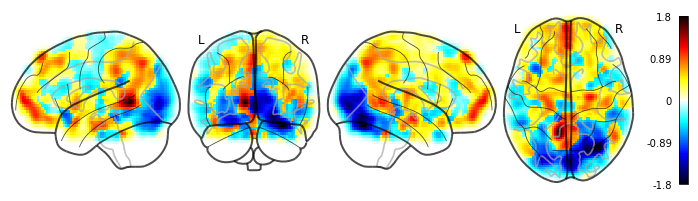

In [3]:
for con_image in spmT_images:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(con_image, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False)

### make group mask

In [11]:
from glob import glob
brainmasks = glob('/data/sub-*/func/*brain_mask.nii.gz')
print(brainmasks[21])

/data/sub-15/func/sub-15_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [ ]:
mean_mask = nilearn.image.mean_img(brainmasks)
# nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

### define params

In [4]:
experiment_dir = '/output'
output_dir = 'first_level'
working_dir = 'workingdir'

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005']

# mask = "/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

### specify nodes

In [5]:
# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

### input/output stream

In [6]:
experiment_dir = '/output'
output_dir = 'first_level'
working_dir = 'workingdir'

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005']

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]
#                         ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(experiment_dir, output_dir, '1stLevel', 'sub-*',
                         '{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
# subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
#                for f in fwhm
#                for con in contrast_list]
# substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

### specify workflow

In [7]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
#                     (gunzip, onesamplettestdes, [('out_file',
#                                                   'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

### run workflow

In [6]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

201007-10:10:31,995 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
201007-10:10:32,49 nipype.workflow INFO:
	 Running in parallel.
201007-10:10:32,56 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201007-10:10:32,211 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0005/selectfiles".
201007-10:10:32,212 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0004/selectfiles".
201007-10:10:32,213 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0003/selectfiles".201007-10:10:32,213 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0002/selectfiles".

201007-

### visualise results

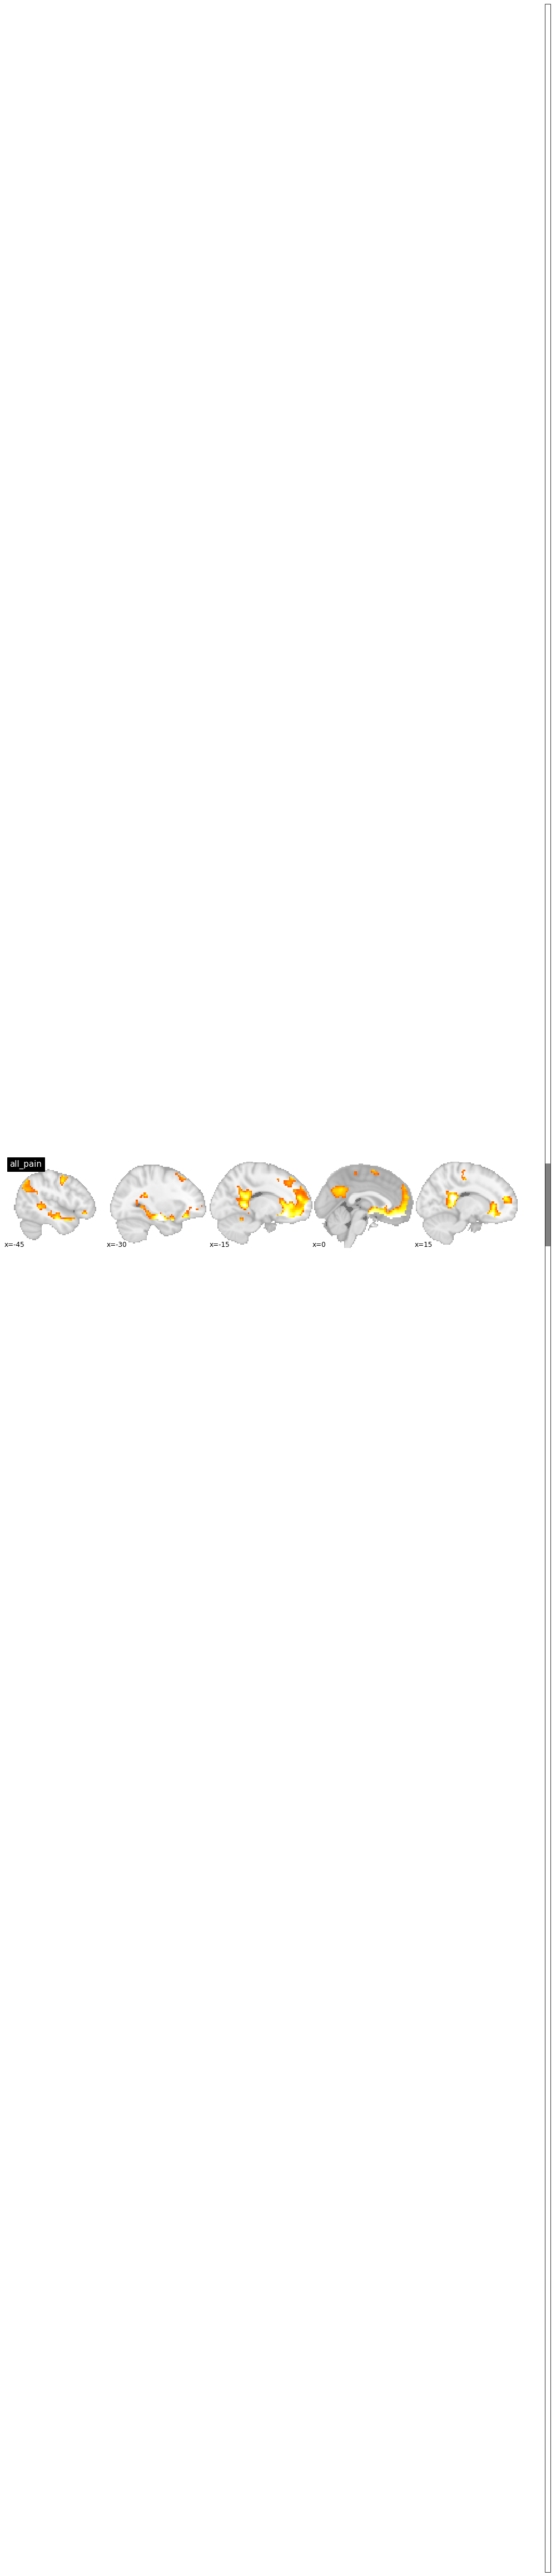

In [10]:
nilearn.plotting.plot_stat_map(
    '/output/first_level/2ndLevel/con_0001/spmT_0001_thr.nii', title='all_pain', dim=1,
    threshold=4, vmax=8, display_mode='x', cut_coords=(-45, -30, -15, 0, 15),
    colorbar=True);

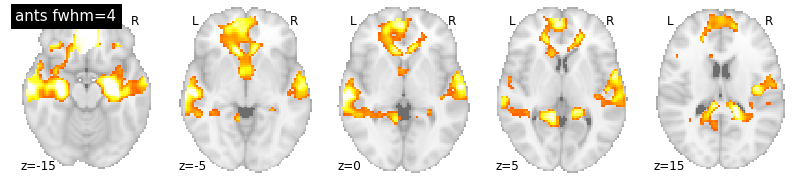

In [34]:
nilearn.plotting.plot_stat_map(
    '/output/first_level/2ndLevel/con_0001/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    threshold=4, vmax=8, display_mode='z', cut_coords=(-15, -5, 0, 5, 15),
    colorbar=False);

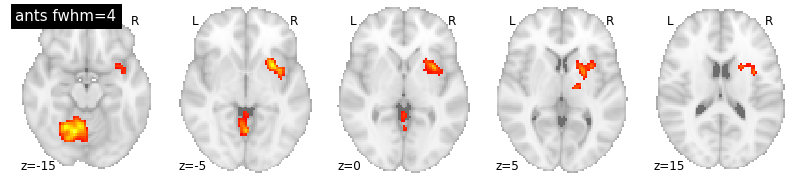

In [37]:
nilearn.plotting.plot_stat_map(
    '/output/first_level/2ndLevel/con_0004/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    threshold=3, vmax=8, display_mode='z', cut_coords=(-15, -5, 0, 5, 15),
    colorbar=False);

### visualise workflow

In [10]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))